In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [2]:
# Load dataset
df = pd.read_csv('D:\Restaurant Recommendation Project\data\clean_data.csv')

In [3]:
import re

# Function to clean unwanted characters in a string
def clean_string(text):
    # Remove any non-ASCII characters
    # Replacing non-ASCII characters with an empty string
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Optionally, replace multiple spaces or unwanted spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Apply the function to the 'name' column to clean it
df['name'] = df['name'].apply(lambda x: clean_string(x) if isinstance(x, str) else x)

In [4]:
# Randomly sample 60% of the data 
df_sample = df.sample(frac=0.4, random_state=42)

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Transform the 'text' column into a matrix of TF-IDF features
tfidf_matrix = vectorizer.fit_transform(df_sample['text'])

# Compute the cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Example: Check the similarity of the first restaurant with others
print(cosine_sim[0])

[1.         0.95472335 0.95254151 ... 0.94348103 0.93333741 0.94502416]


In [5]:
def get_content_based_recommendations(restaurant_name, top_n=5):
    # Get the index of the restaurant that matches the restaurant_name
    idx = df_sample[df_sample['name'] == restaurant_name].index[0]
    
    # Get the pairwise similarity scores of all restaurants with that restaurant
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the restaurants based on similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the input restaurant by starting from the second element (to avoid self-similarity)
    sim_scores = sim_scores[1:]
    
    # List to store recommended restaurants
    recommended_restaurants = []
    
    # Get the top N most similar restaurants (from the sorted list)
    for i in sim_scores:
        restaurant = df_sample['name'].iloc[i[0]]
        
        # Ensure the restaurant is not the input restaurant and not already in the recommendations list
        if restaurant != restaurant_name and restaurant not in recommended_restaurants:
            recommended_restaurants.append(restaurant)
        
        # Stop once we have the exact top N recommendations
        if len(recommended_restaurants) == top_n:
            break
    
    return recommended_restaurants

# Test the recommendation function 
recommended = get_content_based_recommendations('Jalsa', top_n=5)
print("Recommended Restaurants:", recommended)


Recommended Restaurants: ["Royce' Chocolate", 'Yauatcha PTisserie', 'Sugar & Spice - Taj Mg Road Bengaluru', 'Ice N Spice', 'Nithyothsav - Hotel Ramanashree']


### Evaluation Metrics

In [ ]:
# precision
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    
    precision = len([item for item in recommended_k if item in relevant_set]) / k
    return precision

# Example usage
recommended = get_content_based_recommendations('Jalsa', top_n=5)
# relevant_restaurants = ['Spice Elephant', 'Tandoor House', 'The Curry Club']
relevant_restaurants = ['Royce\' Chocolate', 'Yauatcha Patisserie', 'Sugar & Spice - Taj Mg Road Bengaluru']
precision = precision_at_k(recommended, relevant_restaurants, k=3)
print(f"Precision at 3: {precision:.2f}")


Precision at 3: 0.67


Comment: Precision at 3 = 0.67 means that, on average, 67% of the top 3 recommended restaurants are relevant or correct based on your evaluation metric or ground truth.

In [18]:
# recall
def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    
    recall = len([item for item in recommended_k if item in relevant_set]) / len(relevant_set)
    return recall

# Example usage
recall = recall_at_k(recommended, relevant_restaurants, k=3)
print(f"Recall at 3: {recall:.2f}")


Recall at 3: 0.67


Comment: Recall at 3 = 0.67 indicates that the model can still find some relevant recommendations

### Similarity score analysis

In [ ]:
# Function to analyze similarity scores
def analyze_similarity_scores(restaurant_name, top_n=5):
    # Get the index of the restaurant that matches the restaurant_name
    idx = df_sample[df_sample['name'] == restaurant_name].index[0]
    
    # Get the similarity scores of all restaurants with the given restaurant
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the restaurants based on similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the input restaurant by starting from the second element (to avoid self-similarity)
    sim_scores = sim_scores[1:]
    
    # Set to store recommended restaurants and ensure no duplicates
    recommended_restaurants_set = set()
    
    # List to store the top N recommended restaurants
    recommended_restaurants = []
    
    # Get the top N most similar restaurants (from the sorted list)
    for i in sim_scores:
        restaurant = df_sample['name'].iloc[i[0]]
        
        # Ensure the restaurant is not the input restaurant and not already in the set
        if restaurant != restaurant_name and restaurant not in recommended_restaurants_set:
            recommended_restaurants.append((restaurant, i[1]))
            recommended_restaurants_set.add(restaurant)
        
        # Stop once we have the exact top N recommendations
        if len(recommended_restaurants) == top_n:
            break
    
    # Display similarity scores for top N unique restaurants
    print(f"Top {top_n} Similarity Scores for '{restaurant_name}':")
    for restaurant, score in recommended_restaurants:
        print(f"Restaurant: {restaurant}, Similarity Score: {score:.4f}")

# Example usage
analyze_similarity_scores('San Churro Cafe', top_n=5)


Top 5 Similarity Scores for 'San Churro Cafe':
Restaurant: White Plate, Similarity Score: 1.0000
Restaurant: Skydeck By Sherlock'S, Similarity Score: 0.9863
Restaurant: The Barn - Bar & Kitchen, Similarity Score: 0.9716
Restaurant: Ebony, Similarity Score: 0.9708
Restaurant: Best Brews - Four Points By Sheraton Bengaluru..., Similarity Score: 0.9688


Comment: The analysis reveals that 'San Churro Cafe' is most similar to 'White Plate', indicating a very high degree of similarity in terms of menu items, ambience, or other factors. Other similar restaurants like 'Skydeck By Sherlock's' and 'The Barn - Bar & Kitchen' show high similarity but with slight variations, possibly in service style, target audience, or cuisine. The slightly lower similarity scores for 'Ebony' and 'Best Brews - Four Points By Sheraton Bengaluru' suggest that while they share some features, their focus may differ in aspects like food offering, dining experience, or pricing.

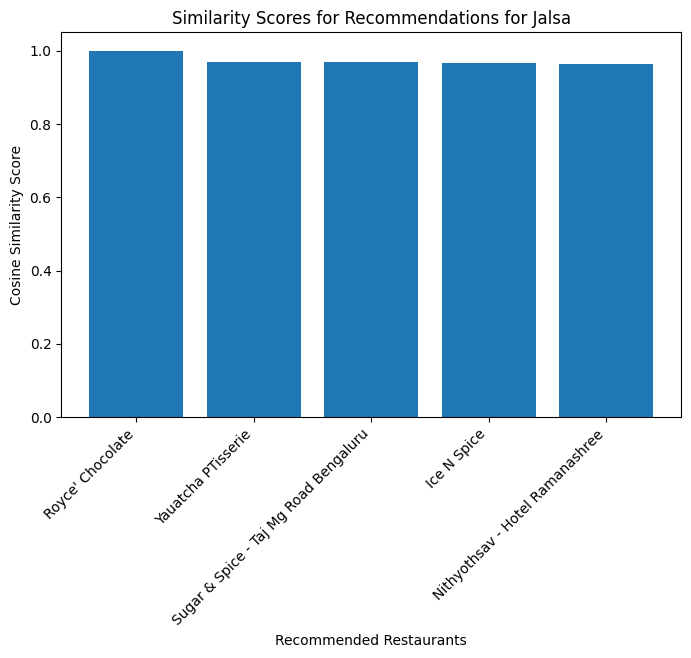

In [21]:
import matplotlib.pyplot as plt

# Function to visualize similarity scores distribution
def visualize_similarity_distribution(restaurant_name, top_n=5):
    idx = df_sample[df_sample['name'] == restaurant_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the input restaurant and get the top N unique recommendations
    sim_scores = sim_scores[1:]
    
    # Set to keep track of unique restaurants
    recommended_restaurants_set = set()
    
    # List to store the top N recommended restaurants and their similarity scores
    unique_sim_scores = []
    
    for score in sim_scores:
        restaurant = df_sample['name'].iloc[score[0]]
        
        # Ensure the restaurant is not the input restaurant and is unique
        if restaurant != restaurant_name and restaurant not in recommended_restaurants_set:
            recommended_restaurants_set.add(restaurant)
            unique_sim_scores.append((restaurant, score[1]))
        
        if len(unique_sim_scores) == top_n:
            break
    
    # Separate the names and scores for plotting
    names = [restaurant for restaurant, _ in unique_sim_scores]
    scores = [score for _, score in unique_sim_scores]
    
    # Plot the similarity scores
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, top_n + 1), scores, tick_label=names)
    plt.xlabel('Recommended Restaurants')
    plt.ylabel('Cosine Similarity Score')
    plt.title(f'Similarity Scores for Recommendations for {restaurant_name}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Example usage
visualize_similarity_distribution('Jalsa', top_n=5)


In [24]:
def save_evaluation_metrics(file_path, recommended, relevant, k=5):
    precision = precision_at_k(recommended, relevant, k)
    recall = recall_at_k(recommended, relevant, k)
    
    
    with open(file_path, 'w') as f:
        f.write(f"Evaluation Metrics at K={k}:\n")
        f.write(f"Precision at {k}: {precision:.2f}\n")
        f.write(f"Recall at {k}: {recall:.2f}\n")
    
    print(f"Evaluation metrics saved to {file_path}")

# Save evaluation metrics to 'output/evaluation.txt'
save_evaluation_metrics('output/evaluation.txt', recommended, relevant_restaurants, k=3)


Evaluation metrics saved to output/evaluation.txt
